In [1]:
import os
import pandas as pd
from functools import reduce
from statsmodels.tsa.stattools import adfuller, kpss
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def adf_test(timeseries, regression = "c"):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC", regression = regression)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries, regression = "c"):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression= regression, nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

def plotseasonal(descomp, axes):
    descomp.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observado')
    descomp.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Tendencia')
    descomp.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Estacionalidad')
    descomp.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residuos')

# Selección de modelos 

## Procesos ARIMA

Si la serie es estacionaria y tanto el ACF como el PACF tiene un patrón decreciente o sinusoidal, el proceso es $ARMA(p,q)$. Si la serie no es estacionaria, se "integra" $d$ veces hasta que lo sea. 

### Caso real

In [37]:
carpeta_base = r"C:\Users\josea\Documents\Insumos Series de Tiempo"
# Leemos la base
serie_ipc = pd.read_excel(os.path.join(carpeta_base, "IPC.xlsx"), skiprows=4)
# Convertimos los meses en español por números
meses = (("Enero", "1"), ("Febrero", "2"), ("Marzo", "3"), ("Abril", "4"), 
         ("Mayo", "5"), ("Junio", "6"), ("Julio","7"), ("Agosto", "8"), 
         ("Septiembre", "9"), ("Octubre", "10"), ("Noviembre", "11"), 
         ("Diciembre", "12"))
serie_ipc.columns = ["Mes", "Nivel", "Var_Mensual", "Var_IA", "Var_Acum"]
serie_ipc['Mes'] = serie_ipc['Mes'].apply(lambda x: reduce(
    lambda a, kv: a.replace(*kv), meses, x))
#Damos formato de fecha
serie_ipc['Mes'] = pd.to_datetime(serie_ipc['Mes'],format = "%m/%Y")
serie_ipc.index = serie_ipc['Mes'] 

In [7]:
# Leemos la base
serie_deuda = pd.read_excel(os.path.join(carpeta_base, "Deuda Interna.xlsx"), skiprows=4)
serie_deuda

,Unnamed: 0,Enero/1988,Febrero/1988,Marzo/1988,Abril/1988,Mayo/1988,Junio/1988,Julio/1988,Agosto/1988,Septiembre/1988,...,Agosto/2023,Septiembre/2023,Octubre/2023,Noviembre/2023,Diciembre/2023,Enero/2024,Febrero/2024,Marzo/2024,Abril/2024,Mayo/2024
0,Total valor nominal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.142944e+07,2.129869e+07,2.133333e+07,2.125966e+07,2.122370e+07,2.113206e+07,2.102511e+07,2.088816e+07,2.113947e+07,2.136349e+07
1,Total valor transado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.073401e+07,2.058086e+07,2.064313e+07,2.055881e+07,2.058339e+07,2.052990e+07,2.044842e+07,2.037976e+07,2.060153e+07,2.068418e+07
2,Sociedades de Depósitos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.194745e+06,4.083990e+06,4.094883e+06,3.976031e+06,3.881883e+06,3.753020e+06,3.691042e+06,3.609776e+06,3.600534e+06,3.585028e+06
3,Sociedades de depósitos bancarios,17131.0,15960.0,18935.0,20273.0,19407.0,18331.0,17756.0,15946.0,20230.0,...,3.235293e+06,3.142911e+06,3.178323e+06,3.066424e+06,2.966090e+06,2.858981e+06,2.802530e+06,2.750708e+06,2.742995e+06,2.727489e+06
4,Banco Central de Costa Rica,1916.0,1824.0,1816.0,1816.0,1793.0,1785.0,1785.0,1773.0,1764.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,Bancos Públicos,14839.0,13660.0,16649.0,17757.0,16906.0,15667.0,15346.0,13434.0,17761.0,...,2.031732e+06,1.972982e+06,2.007155e+06,1.896949e+06,1.802915e+06,1.690092e+06,1.684770e+06,1.682314e+06,1.710270e+06,1.668227e+06
6,Bancos Privados,376.0,476.0,470.0,700.0,708.0,879.0,625.0,739.0,705.0,...,1.203561e+06,1.169929e+06,1.171168e+06,1.169475e+06,1.163175e+06,1.168889e+06,1.117760e+06,1.068394e+06,1.032725e+06,1.059262e+06
7,Otras sociedades de depósito no banc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.594522e+05,9.410784e+05,9.165604e+05,9.096065e+05,9.157925e+05,8.940389e+05,8.885121e+05,8.590673e+05,8.575392e+05,8.575392e+05
8,Cooperativas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.888532e+05,5.666271e+05,5.533551e+05,5.376979e+05,5.350357e+05,5.139508e+05,5.037346e+05,4.850346e+05,4.729975e+05,4.729975e+05
9,Financieras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.295546e+04,3.158082e+04,3.155764e+04,3.150976e+04,3.132763e+04,2.911995e+04,2.792056e+04,2.938697e+04,2.938412e+04,2.938412e+04


In [8]:
serie_deuda = pd.melt(serie_deuda, id_vars = "Unnamed: 0",var_name='Mes', value_name='Monto')
serie_deuda = serie_deuda[serie_deuda["Unnamed: 0"] == "Total valor nominal"]
serie_deuda

,Unnamed: 0,Mes,Monto
0,Total valor nominal,Enero/1988,NaN
18,Total valor nominal,Febrero/1988,NaN
36,Total valor nominal,Marzo/1988,NaN
54,Total valor nominal,Abril/1988,NaN
72,Total valor nominal,Mayo/1988,NaN
...,...,...,...
7776,Total valor nominal,Enero/2024,2.113206e+07
7794,Total valor nominal,Febrero/2024,2.102511e+07
7812,Total valor nominal,Marzo/2024,2.088816e+07
7830,Total valor nominal,Abril/2024,2.113947e+07


In [9]:
serie_deuda['Mes'][serie_deuda["Monto"].isna()][-1:]

612    Noviembre/1990
Name: Mes, dtype: object

In [10]:
# Convertimos los meses en español por números
meses = (("Enero", "1"), ("Febrero", "2"), ("Marzo", "3"), ("Abril", "4"), 
         ("Mayo", "5"), ("Junio", "6"), ("Julio","7"), ("Agosto", "8"), 
         ("Septiembre", "9"), ("Octubre", "10"), ("Noviembre", "11"), 
         ("Diciembre", "12"))
serie_deuda['Mes'] = serie_deuda['Mes'].apply(lambda x: reduce(
    lambda a, kv: a.replace(*kv), meses, x))
#Damos formato de fecha
serie_deuda['Mes'] = pd.to_datetime(serie_deuda['Mes'],format = "%m/%Y")
serie_deuda.index = serie_deuda['Mes'] 

In [11]:
serie_deuda = serie_deuda.loc[serie_deuda["Mes"] > pd.to_datetime("1990-11-01")]
plt.plot(serie_deuda.Monto);

In [45]:
#Real
serie_deuda = pd.merge(serie_deuda[["Monto"]], serie_ipc[["Nivel"]], on = "Mes", how = "left")
serie_deuda['Real'] = 100/serie_deuda["Nivel"]*serie_deuda["Monto"]
serie_deuda.index.freq = 'MS'

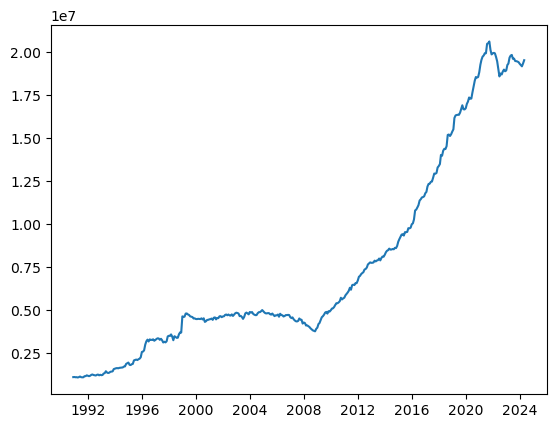

In [51]:
plt.plot(serie_deuda.Real);

In [53]:
adf_test(serie_deuda.Real, regression = "c")

Results of Dickey-Fuller Test:
Test Statistic                   0.901523
p-value                          0.993110
#Lags Used                      12.000000
Number of Observations Used    389.000000
Critical Value (1%)             -3.447273
Critical Value (5%)             -2.868999
Critical Value (10%)            -2.570743
dtype: float64


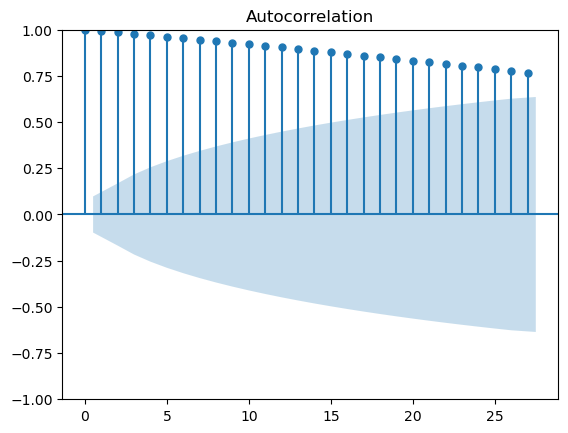

In [55]:
plot_acf(serie_deuda.Real)
plt.show()

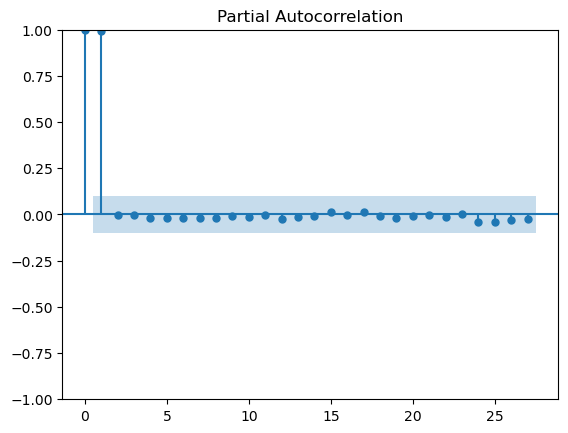

In [57]:
plot_pacf(serie_deuda.Real)
plt.show()

In [59]:
#Buscamos el i
eps_diff = serie_deuda.Real
for d in range(1,13):
    eps_diff = eps_diff.diff()
    pvalue = adfuller(eps_diff.dropna())[1]
    print(f"Lag: {d} p-valor: {pvalue}")


Lag: 1 p-valor: 0.006885594456300907
Lag: 2 p-valor: 2.7992698163524307e-17
Lag: 3 p-valor: 2.6819276303700505e-15
Lag: 4 p-valor: 1.1277687710492182e-19
Lag: 5 p-valor: 1.3820020734361008e-23
Lag: 6 p-valor: 3.5276756998883506e-26
Lag: 7 p-valor: 3.6779346402009065e-28
Lag: 8 p-valor: 2.403567245656329e-29
Lag: 9 p-valor: 4.540722872713848e-30
Lag: 10 p-valor: 0.0
Lag: 11 p-valor: 0.0
Lag: 12 p-valor: 0.0


In [61]:
eps_diff = serie_deuda.Real
pvalue = 1
d = 1
while (pvalue > 0.05) & (d < 13):
    eps_diff = eps_diff.diff()
    pvalue = adfuller(eps_diff.dropna())[1]
    print(f"Lag: {d} p-valor: {pvalue}")
    d += 1

Lag: 1 p-valor: 0.006885594456300907


In [67]:
serie_estacionaria = serie_deuda.Real.diff().dropna()

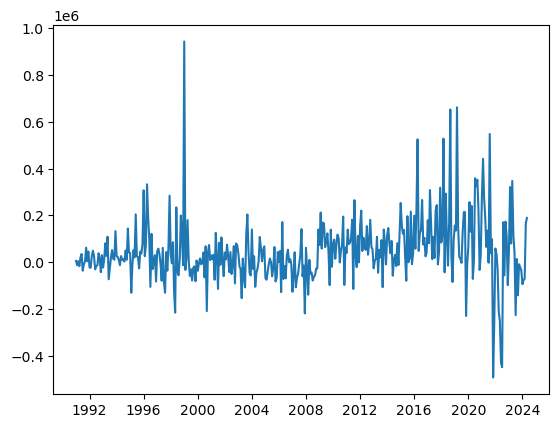

In [69]:
plt.plot(serie_estacionaria);

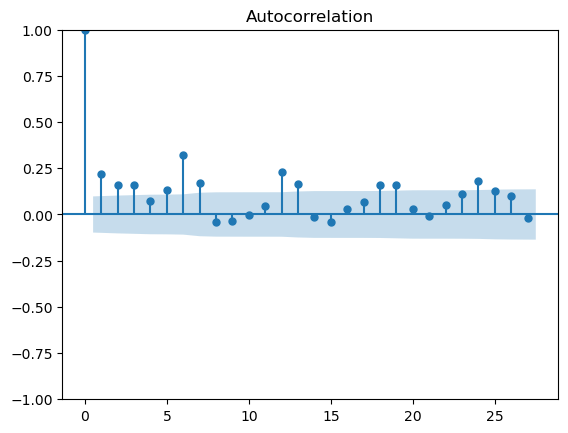

In [71]:
plot_acf(serie_estacionaria)
plt.show()

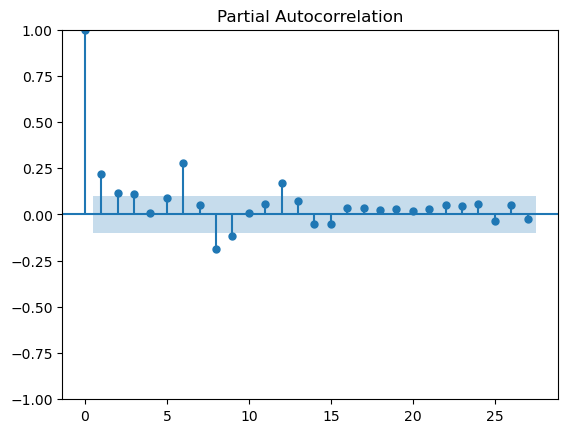

In [73]:
plot_pacf(serie_estacionaria)
plt.show()

In [143]:

from itertools import product

def optimize_ARIMA(endog, order_list, d):
    results = []
    for order in order_list:
        print(order)
        try:
            model = sm.tsa.SARIMAX(endog, order=(order[0], d, order[1]),simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    return result_df

In [145]:
len(serie_deuda.Real)

402

In [186]:
train = serie_deuda.Real.head(402-12)
test = serie_deuda.Real.tail(12)
ps = range(1, 4, 1)
qs = range(1, 4, 1)
d = 1
order_list = list(product(ps, qs))
optimize_ARIMA(train, order_list, d)

(1, 1)
(1, 2)
(1, 3)
(2, 1)


C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(2, 2)


C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 3)
(3, 1)
(3, 2)


C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 3)


C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(3, 3)",10277.656359
1,"(2, 2)",10280.734052
2,"(2, 1)",10281.401296
3,"(1, 2)",10281.664183
4,"(1, 1)",10282.198096
5,"(1, 3)",10283.009793
6,"(3, 1)",10283.077333
7,"(3, 2)",10284.869940
8,"(2, 3)",10285.154434


# Pruebas estadísticas

In [198]:
modelo_deuda = sm.tsa.SARIMAX(train, order = (3,1,3))
resultado = modelo_deuda.fit()
resultado.summary()

C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Real   No. Observations:                  390
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -5131.828
Date:                Fri, 26 Jul 2024   AIC                          10277.656
Time:                        07:13:41   BIC                          10305.401
Sample:                    12-01-1990   HQIC                         10288.656
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8568      0.040     21.574      0.000       0.779       0.935
ar.L2         -0.7610      0.061    -12.393      0.000      -0.881      -0.641
ar.L3          0.8708      0.049     17.902      0.000       0.775       0.966
ma.L1         -0.8066      0.031    -26.118      0.000      -0.867      -0.746
ma.L2          0.8558      0.043     19.712      0.000       0.771       0.941
ma.L3         -0.9137      0.033    -27.556      0.000      -0.979      -0.849
sigma2      1.731e+10   5.06e-12   3.42e+21      0.000    1.73e+10    1.73e+10
===================================================================================
Ljung-Box (L1) (Q):                   4.59   Jarque-Bera (JB):              1303.39
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.84e+36. Standard errors may be unstable.
"""

* **Ljung-Box**: Prueba de autocorrelación de los residuos. La hipótesis nula es que los datos se distribuyen de forma independiente. Cumple si p-valor es mayor a 5%.
* **Heterocedastidad**: H0: no hay heterocedasticidad.
* **Jarque-Bera**: Prueba de normalidad de los residuos (asimetría y curtosis). 

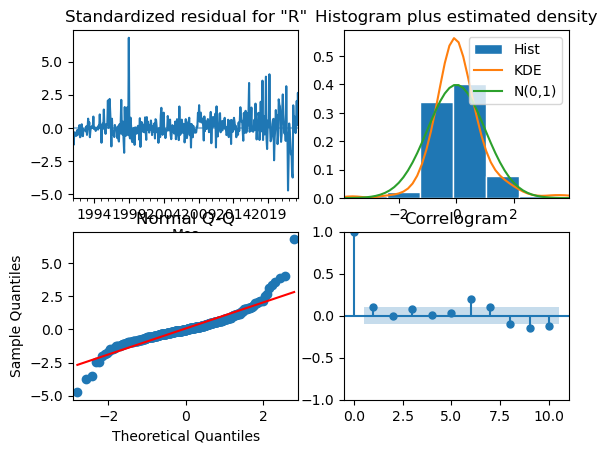

In [200]:
resultado.plot_diagnostics()
plt.show()

In [203]:
from statsmodels.stats.diagnostic import acorr_ljungbox,lilliefors
residuals = resultado.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,2.190341,0.138879
2,2.451738,0.293503
3,3.666881,0.299754
4,3.674244,0.451883
5,3.834287,0.573513
6,13.755442,0.032491
7,16.111528,0.024117
8,19.443612,0.012659
9,26.458613,0.001718
10,30.957896,0.000596


In [205]:
lilliefors(residuals, dist='norm')[1]

0.0009999999999998899